# CONTEXTO

En este problema se dispone de un conjunto de datos compuesto por imágenes de escenas naturales provenientes de distintas regiones del mundo. El objetivo es desarrollar modelos de clasificación que permitan asignar cada imagen a una de las seis categorías predefinidas, utilizando distintos enfoques de aprendizaje profundo: redes densas, redes neuronales convolucionales (CNN), arquitecturas basadas en ResNet y modelos de Transfer Learning.


https://drive.google.com/file/d/1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ/view?usp=drive_link


El dataset proporcionado contiene alrededor de 25,000 imágenes de tamaño 150x150, distribuidas en seis categorías:

* buildings
* forest
* glacier
* mountain
* sea
* street

Las imágenes están divididas en tres conjuntos (carpetas):

**Train:** Alrededor de 14,000 imágenes para entrenamiento.

**Test:** Alrededor de 3,000 imágenes para evaluación del modelo.

**Prediction:** Alrededor de 7,000 imágenes para predicción final.

# Preparación del Entorno


## Importar Librerias

In [ ]:
!pip install gdown --quiet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import gdown
import zipfile
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from keras.layers import Input, Concatenate, Flatten, BatchNormalization, Add, Activation, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers import Dense, Conv2D, MaxPooling2D, Rescaling, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing import image



Configurar para que TensorFlow utilice la GPU por defecto

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


Descarga del Dataset

In [ ]:
url = 'https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ'  # formato directo de Drive
output = 'dataset_scenes.zip'  # nombre del archivo local
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=3d9819c2-a07a-4055-be6f-dfaf948b15c3
To: /content/dataset_scenes.zip
100%|██████████| 363M/363M [00:07<00:00, 46.1MB/s]


'dataset_scenes.zip'

In [ ]:
with zipfile.ZipFile('dataset_scenes.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset_scenes')

In [ ]:
base_dir = 'dataset_scenes'
# Mostrar carpetas principales
print(os.listdir(base_dir))

['seg_test', 'seg_pred', 'seg_train']


In [ ]:
train_dir = os.path.join(base_dir, 'seg_train', 'seg_train')
test_dir = os.path.join(base_dir, 'seg_test', 'seg_test')
pred_dir = os.path.join(base_dir, 'seg_pred', 'seg_pred')

for folder in [train_dir, test_dir, pred_dir]:
    if os.path.exists(folder):
        print(f"\nContenido de {folder}:")
        print(os.listdir(folder))
    else:
        print(f"No se encontró la carpeta: {folder}")



Contenido de dataset_scenes/seg_train/seg_train:
['street', 'glacier', 'forest', 'sea', 'mountain', 'buildings']

Contenido de dataset_scenes/seg_test/seg_test:
['street', 'glacier', 'forest', 'sea', 'mountain', 'buildings']

Contenido de dataset_scenes/seg_pred/seg_pred:
['20744.jpg', '15698.jpg', '3156.jpg', '15731.jpg', '1324.jpg', '17351.jpg', '2794.jpg', '16361.jpg', '8272.jpg', '1990.jpg', '4019.jpg', '24227.jpg', '13974.jpg', '11884.jpg', '16232.jpg', '5671.jpg', '2081.jpg', '11445.jpg', '13321.jpg', '11907.jpg', '11158.jpg', '18818.jpg', '7800.jpg', '11738.jpg', '3832.jpg', '20339.jpg', '6448.jpg', '1037.jpg', '4664.jpg', '19062.jpg', '9545.jpg', '18377.jpg', '1433.jpg', '16265.jpg', '24014.jpg', '24162.jpg', '16689.jpg', '6176.jpg', '10395.jpg', '23460.jpg', '591.jpg', '6521.jpg', '5070.jpg', '19479.jpg', '15041.jpg', '2216.jpg', '12851.jpg', '19322.jpg', '614.jpg', '12132.jpg', '10625.jpg', '23395.jpg', '13365.jpg', '24278.jpg', '13318.jpg', '23704.jpg', '19614.jpg', '9429.j

Establecemos las direcciones de train, test y del conjunto a predecir.

In [ ]:
train_dir = 'dataset_scenes/seg_train/seg_train'
test_dir = 'dataset_scenes/seg_test/seg_test'
pred_dir = 'dataset_scenes/seg_pred/seg_pred'


Data augmentation para el conjunto de entrenamiento.

In [ ]:
train_datagen = ImageDataGenerator(
  rescale=1./255,           # Normaliza los píxeles de 0-255 a 0-1
  rotation_range=20,        # Rotación aleatoria de la imagen hasta 20 grados
  width_shift_range=0.2,    # Desplazamiento horizontal aleatorio hasta 20% del ancho
  height_shift_range=0.2,   # Desplazamiento vertical aleatorio hasta 20% de la altura
  shear_range=0.2,          # Aplica cizallamiento (shear) aleatorio
  zoom_range=0.2,           # Zoom aleatorio hasta 20%
  horizontal_flip=True,     # Voltea horizontalmente la imagen aleatoriamente
  fill_mode='nearest'       # Cómo rellenar los píxeles vacíos después de transformaciones
)

Para los datos de prueba sólo normalizamos los píxeles.

In [ ]:
# Solo normalización para prueba
test_datagen = ImageDataGenerator(rescale=1./255)

Creamos un generador de datos para el conjunto de entrenamiento.

In [ ]:
train_generator = train_datagen.flow_from_directory(
  train_dir,                # Carpeta de entrenamiento.  Keras lee automáticamente las subcarpetas como clases y devuelve las imágenes etiquetadas.
  target_size=(150, 150),   # Redimensiona todas las imágenes a 150x150 píxeles
  batch_size=32,            # Número de imágenes que se cargan por batch
  class_mode='categorical'  # Las etiquetas se codifican en one-hot (6 clases)
)


Found 14034 images belonging to 6 classes.


Creamos un generador de datos para los datos de prueba.

In [ ]:
test_generator = test_datagen.flow_from_directory(
  test_dir,                 # Carpeta de prueba
  target_size=(150, 150),   # Redimensiona a 150x150
  batch_size=16,            # Tamaño del batch
  class_mode='categorical',  # Codificación one-hot
  shuffle=False             # No barajamos los datos de prueba
)


Found 3000 images belonging to 6 classes.


In [ ]:
# Verificar clases y cantidad de imágenes
print("Clases detectadas:", train_generator.class_indices)

print("Número de imágenes de entrenamiento:", train_generator.samples)
print("Número de imágenes de prueba:", test_generator.samples)


Clases detectadas: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Número de imágenes de entrenamiento: 14034
Número de imágenes de prueba: 3000


Distribución de clases en el conjunto de entrenamiento:
buildings: 2191 imágenes
forest: 2271 imágenes
glacier: 2404 imágenes
mountain: 2512 imágenes
sea: 2274 imágenes
street: 2382 imágenes


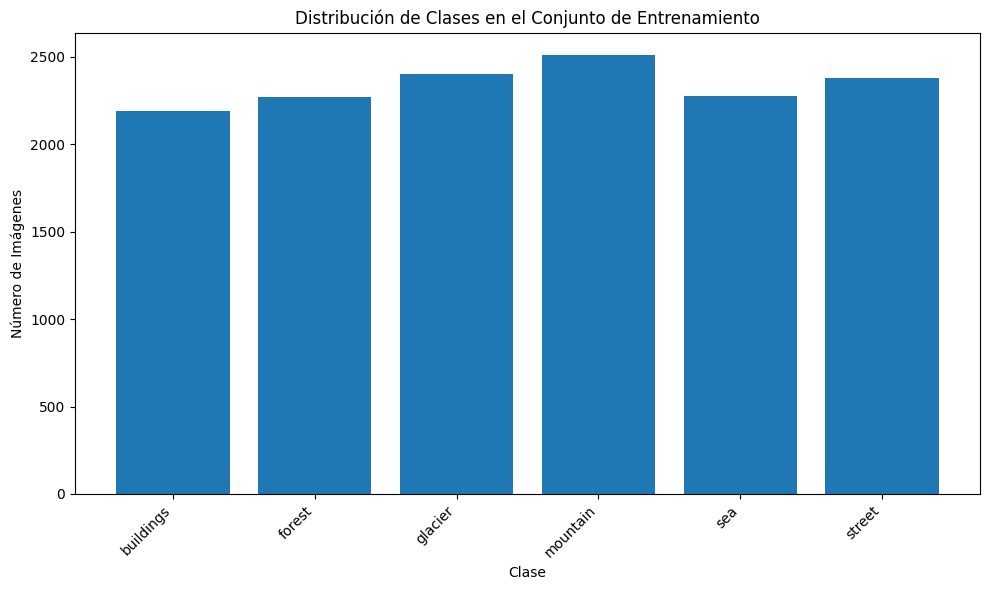

In [ ]:
# Verificar que las clases estan balanceadas
class_indices = train_generator.class_indices
# Obtener las etiquetas de clase para cada imagen
labels = train_generator.labels
# Contar cuántas imágenes hay por cada clase
class_counts = np.bincount(labels)

print("Distribución de clases en el conjunto de entrenamiento:")
for class_name, class_index in class_indices.items():
    print(f"{class_name}: {class_counts[class_index]} imágenes")

plt.figure(figsize=(10, 6))
plt.bar(class_indices.keys(), class_counts)
plt.xlabel("Clase")
plt.ylabel("Número de Imágenes")
plt.title("Distribución de Clases en el Conjunto de Entrenamiento")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Observamos que el desbalance es leve.



Visualizamos algunas de las imagenes generadas en el conjunto de entrenamiento.

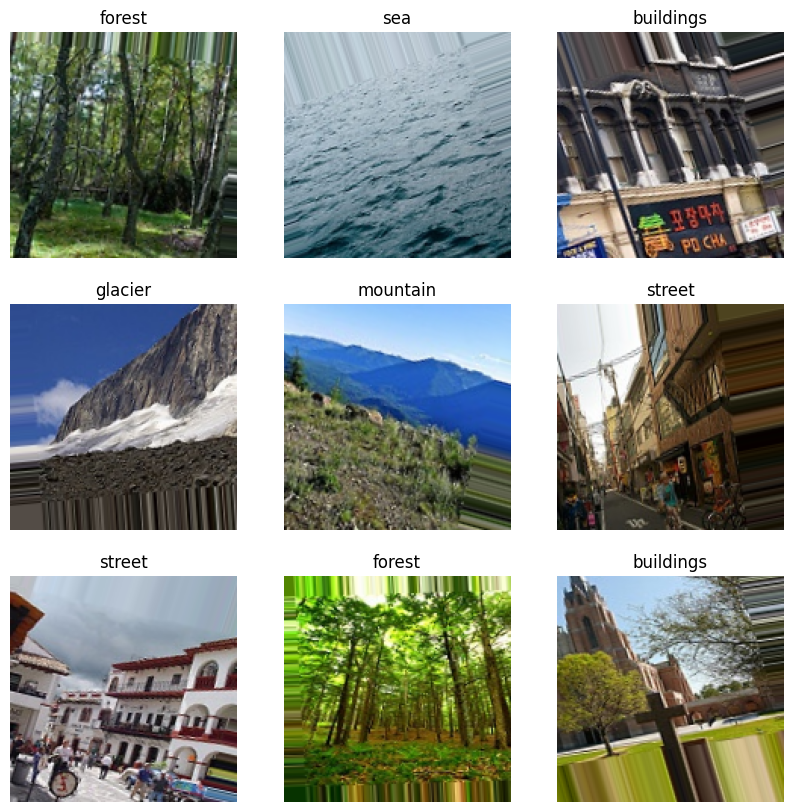

In [ ]:
# Muestra algunas imágenes de ejemplo
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
  for i in range(min(len(images), 9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    class_idx = list(labels[i]).index(1)
    plt.title(list(train_generator.class_indices.keys())[class_idx])
    plt.axis("off")
  break

# Modelo con Capas Densas


Definimos y compilamos el modelo secuencial de capas densas.

In [ ]:
model_dense = Sequential([
    Input(shape=(150, 150, 3)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(6, activation='softmax')
])

In [ ]:
model_dense.compile(optimizer="adam",
                loss='categorical_crossentropy',
                metrics=['accuracy'])

#Resumen del modelo
model_dense.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     4,320,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,322,342 (16.49 MB)

 Trainable params: 4,322,342 (16.49 MB)

 Non-trainable params: 0 (0.00 B)

Entrenamos el modelo.

In [ ]:
# Train the model
history_dense = model_dense.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 89s 191ms/step - accuracy: 0.1823 - loss: 3.0902 - val_accuracy: 0.1753 - val_loss: 1.7900
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 78s 179ms/step - accuracy: 0.1811 - loss: 1.7904 - val_accuracy: 0.1757 - val_loss: 1.7896
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 80s 181ms/step - accuracy: 0.1773 - loss: 1.7904 - val_accuracy: 0.1753 - val_loss: 1.7897
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 79s 180ms/step - accuracy: 0.1801 - loss: 1.7909 - val_accuracy: 0.1753 - val_loss: 1.7896
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 79s 179ms/step - accuracy: 0.1815 - loss: 1.7903 - val_accuracy: 0.1757 - val_loss: 1.7896
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 79s 180ms/step - accuracy: 0.1828 - loss: 1.7904 - val_accuracy: 0.1763 - val_loss: 1.7890
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 79s 180ms/step - accuracy: 0.1802 - loss: 1.7947 - val_accuracy: 0.1753 - val_loss: 1.7899
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 82s 186ms/step - accuracy: 0.1765 - loss: 1

Visualizamos la exactitud (accuracy) y la función de pérdida para los datos de entrenamiento y validación.

In [ ]:
# Obtener las métricas del entrenamiento
val_acc = history_dense.history['val_accuracy']
val_loss = history_dense.history['val_loss']

# Calcular los mejores valores
best_val_acc = max(val_acc)
best_val_loss = min(val_loss)
best_epoch = np.argmax(val_acc) + 1  # +1 porque los índices empiezan en 0

print(f"✅ Mejor Epoch: {best_epoch}")
print(f"📈 Mejor Valid Accuracy: {best_val_acc:.4f}")
print(f"📉 Mejor Valid Loss: {best_val_loss:.4f}")

✅ Mejor Epoch: 6
📈 Mejor Valid Accuracy: 0.1763
📉 Mejor Valid Loss: 1.7890


Evaluamos el modelo para el conjunto de test.

In [ ]:
# Evaluación en el conjunto de test
test_loss_dense, test_acc_dense = model_dense.evaluate(test_generator, verbose=1)
print(f"Test Accuracy Dense: {test_acc_dense:.4f}")
print(f"Test Loss Dense: {test_loss_dense:.4f}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.0985 - loss: 1.8174
Test Accuracy Dense: 0.1753
Test Loss Dense: 1.7899


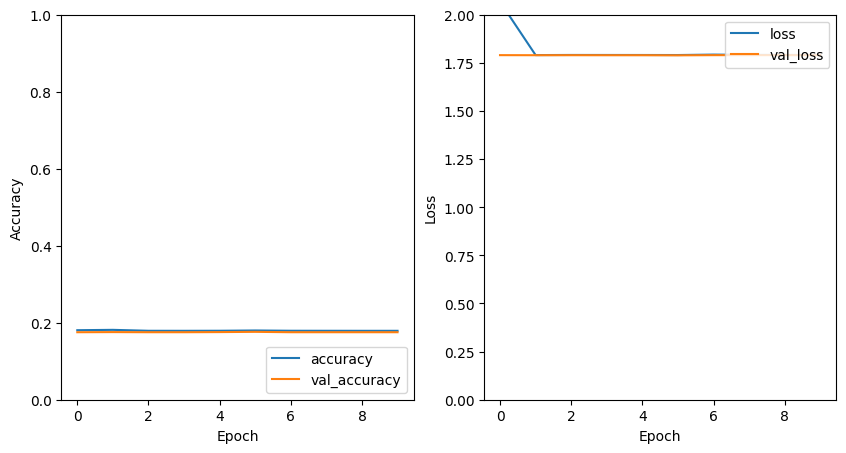

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dense.history['accuracy'], label='accuracy')
plt.plot(history_dense.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_dense.history['loss'], label='loss')
plt.plot(history_dense.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='upper right')

El modelo logra una exactitud (accuracy) de 0.1753 para los datos de test. No tiene una buena generalización y se puede observar que el modelo no aprende con el paso de las épocas.

## Prediccion con Densas

188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


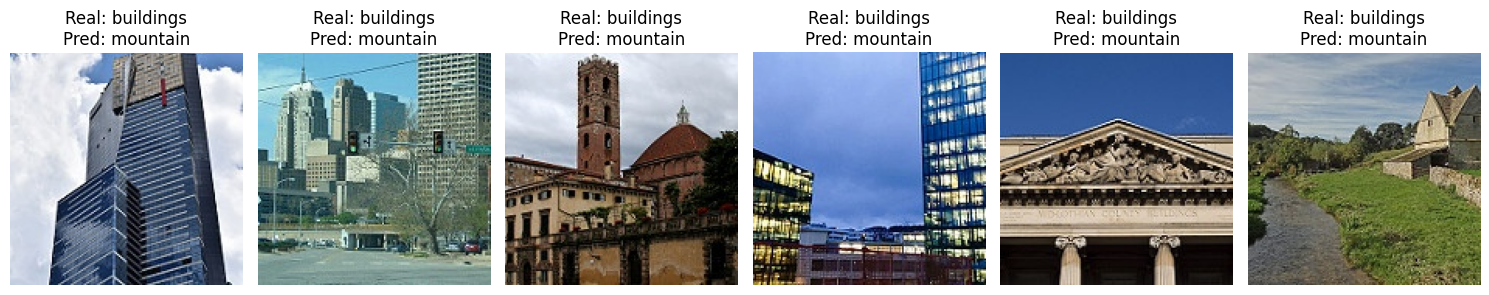

In [ ]:
# Predicciones sobre el conjunto de test
predictions_dense = model_dense.predict(test_generator, verbose=1)

# Convertir de probabilidades a clases
y_pred_dense = np.argmax(predictions_dense, axis=1)

# Obtener un batch del conjunto de test
x_batch, y_batch = next(test_generator)

# Asegurarnos de que el batch tenga al menos 6 imágenes
num_images = min(6, len(x_batch))

# Obtener nombres de clases
class_names = list(test_generator.class_indices.keys())

# Crear una figura para mostrar 6 imágenes
plt.figure(figsize=(15, 5))

for i in range(num_images):
    img = x_batch[i]
    true_label = np.argmax(y_batch[i])

    # Hacer la predicción
    pred_dense = model_dense.predict(np.expand_dims(img, axis=0), verbose=0)
    pred_label_dense = np.argmax(pred_dense)

    # Subplot para cada imagen
    plt.subplot(1, num_images, i+1)
    plt.imshow((img * 255).astype("uint8"))
    plt.axis('off')
    plt.title(f"Real: {class_names[true_label]}\nPred: {class_names[pred_label_dense]}")

plt.tight_layout()
plt.show()

# Modelo con Capas Convolucionales y Densas

Definimos y compilamos el modelo con capas convolucionales y densas.

In [ ]:
model_cnn= models.Sequential([
    Input(shape=(150, 150, 3)),
    # Primera capa convolucional: 32 filtros 3x3, activación ReLU
    layers.Conv2D(32, (3,3), activation='relu'),

    # Capa de pooling: reduce la dimensionalidad a la mitad
    layers.MaxPooling2D(2,2),

    # Segunda capa convolucional: 64 filtros 3x3
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    # Tercera capa convolucional: 128 filtros 3x3
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    # Aplanamos la salida 3D a 1D para conectarla con capas densas
    layers.Flatten(),

    # Capa densa con 128 neuronas y activación ReLU
    layers.Dense(64, activation='relu'),

    # Dropout: descarta aleatoriamente 50% de neuronas durante entrenamiento para evitar overfitting
    layers.Dropout(0.2),

    # Capa de salida: 6 neuronas (una por clase), activación softmax para clasificación multi-clase
    layers.Dense(6, activation='softmax')
])

In [ ]:
model_cnn.compile(
    optimizer='adam',                 # Optimizer: algoritmo para actualizar los pesos durante el entrenamiento
    loss='categorical_crossentropy',  # Función de pérdida para clasificación multi-clase (6 clases)
    metrics=['accuracy']              # Métrica para evaluar rendimiento: exactitud
)


In [ ]:
#Resumen del modelo
model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │     2,367,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,461,190 (9.39 MB)

 Trainable params: 2,461,190 (9.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_cnn = model_cnn.fit(
    train_generator,       # Generador de entrenamiento que entrega batches de imágenes + etiquetas
    validation_data=test_generator,  # Generador de prueba para calcular la pérdida y exactitud en cada época
    epochs=15              # Número de veces que el modelo recorrerá todo el conjunto de entrenamiento
)


Epoch 1/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 95s 205ms/step - accuracy: 0.4678 - loss: 1.3040 - val_accuracy: 0.7097 - val_loss: 0.8067
Epoch 2/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 86s 196ms/step - accuracy: 0.6292 - loss: 0.9506 - val_accuracy: 0.7640 - val_loss: 0.7056
Epoch 3/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 87s 197ms/step - accuracy: 0.6982 - loss: 0.8191 - val_accuracy: 0.7870 - val_loss: 0.6061
Epoch 4/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 85s 193ms/step - accuracy: 0.7329 - loss: 0.7234 - val_accuracy: 0.7853 - val_loss: 0.6154
Epoch 5/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 84s 192ms/step - accuracy: 0.7573 - loss: 0.6743 - val_accuracy: 0.7917 - val_loss: 0.6062
Epoch 6/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 85s 193ms/step - accuracy: 0.7750 - loss: 0.6345 - val_accuracy: 0.7927 - val_loss: 0.6093
Epoch 7/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 84s 192ms/step - accuracy: 0.7765 - loss: 0.6257 - val_accuracy: 0.8373 - val_loss: 0.4887
Epoch 8/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 84s 192ms/step - accuracy: 0.7850 - loss: 0

Visualizamos la precisión (accuracy) y la función de pérdida para los datos de entrenamiento y validación.

In [ ]:
# Obtener las métricas del entrenamiento
val_acc = history_cnn.history['val_accuracy']
val_loss = history_cnn.history['val_loss']

# Calcular los mejores valores
best_val_acc = max(val_acc)
best_val_loss = min(val_loss)
best_epoch = np.argmax(val_acc) + 1  # +1 porque los índices empiezan en 0

print(f"✅ Mejor Epoch: {best_epoch}")
print(f"📈 Mejor Valid Accuracy: {best_val_acc:.4f}")
print(f"📉 Mejor Valid Loss: {best_val_loss:.4f}")

✅ Mejor Epoch: 15
📈 Mejor Valid Accuracy: 0.8597
📉 Mejor Valid Loss: 0.4063


Evaluamos el modelo para el conjunto de test.

In [ ]:
# Evaluación en el conjunto de test
test_loss_cnn, test_acc_cnn = model_cnn.evaluate(test_generator, verbose=1)
print(f"Test Accuracy CNN: {test_acc_cnn:.4f}")
print(f"Test Loss CNN: {test_loss_cnn:.4f}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8717 - loss: 0.3562
Test Accuracy CNN: 0.8597
Test Loss CNN: 0.4081


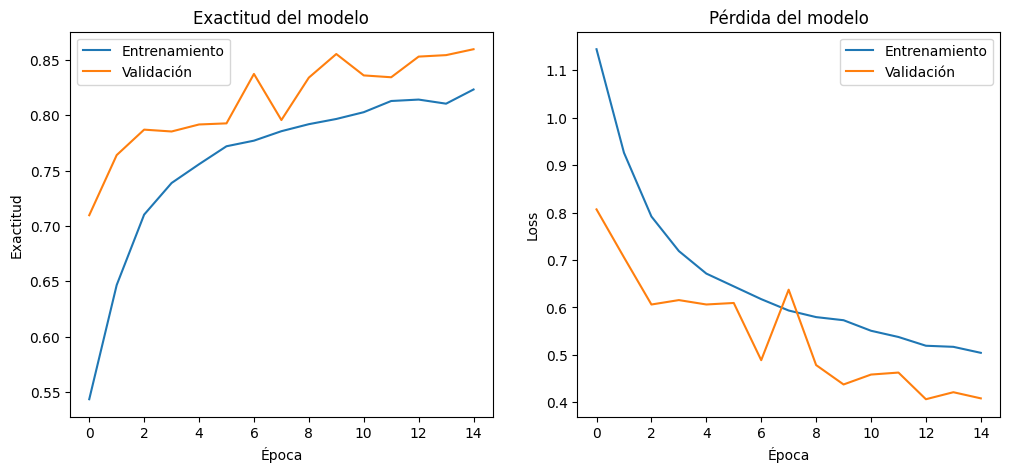

In [ ]:
plt.figure(figsize=(12,5))

# Exactitud
plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'], label='Entrenamiento')
plt.plot(history_cnn.history['val_accuracy'], label='Validación')
plt.title('Exactitud del modelo')
plt.xlabel('Época')
plt.ylabel('Exactitud')
plt.legend()

# Pérdida
plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'], label='Entrenamiento')
plt.plot(history_cnn.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.show()


El modelo logra un accuracy de 0.8483 para los datos de test y
no se observan signos de overfitting.

## Prediccion con CNN

188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


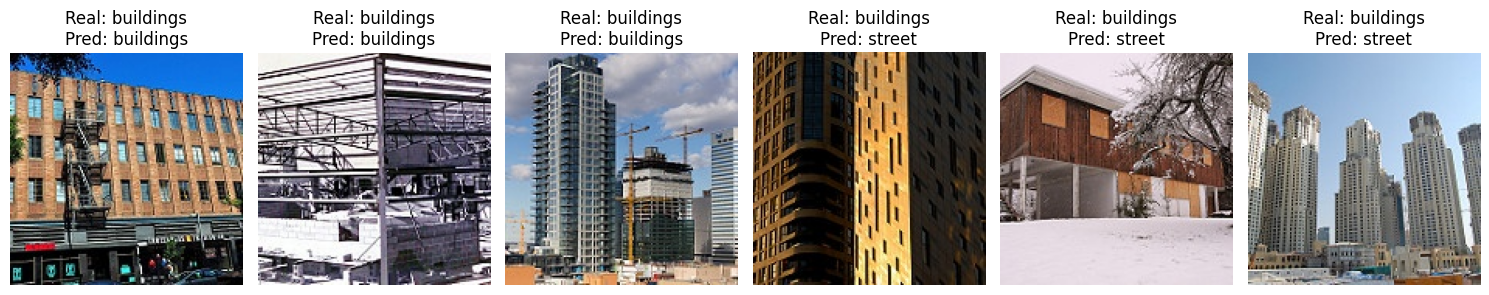

In [ ]:
# Predicciones sobre el conjunto de test
predictions_cnn = model_cnn.predict(test_generator, verbose=1)

# Convertir de probabilidades a clases
y_pred_cnn = np.argmax(predictions_cnn, axis=1)

# Obtener un batch del conjunto de test
x_batch, y_batch = next(test_generator)

# Asegurarnos de que el batch tenga al menos 6 imágenes
num_images = min(6, len(x_batch))

# Obtener nombres de clases
class_names = list(test_generator.class_indices.keys())

# Crear una figura para mostrar 6 imágenes
plt.figure(figsize=(15, 5))

for i in range(num_images):
    img = x_batch[i]
    true_label = np.argmax(y_batch[i])

    # Hacer la predicción
    pred_cnn = model_cnn.predict(np.expand_dims(img, axis=0), verbose=0)
    pred_label_cnn = np.argmax(pred_cnn)

    # Subplot para cada imagen
    plt.subplot(1, num_images, i+1)
    plt.imshow((img * 255).astype("uint8"))
    plt.axis('off')
    plt.title(f"Real: {class_names[true_label]}\nPred: {class_names[pred_label_cnn]}")

plt.tight_layout()
plt.show()

# Modelo con Bloque Residual de Identidad


Definimos y compilamos el modelo ResNet.

In [ ]:
def resnet_module(x, filters, strides=1):
  shortcut = x

  x = Conv2D(filters=filters, kernel_size=(3, 3), strides=strides, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(filters=filters, kernel_size=(3, 3), strides=1, padding='same')(x)
  x = BatchNormalization()(x)

  if strides != 1 or shortcut.shape[-1] != filters:
      shortcut = Conv2D(filters=filters, kernel_size=(1, 1), strides=strides, padding='same')(shortcut)
      shortcut = BatchNormalization()(shortcut)

  x = Add()([x, shortcut])
  x = Activation('relu')(x)

  return x

def resnet_model(input_shape, num_classes):
  inputs = Input(shape=input_shape)

  #x = Rescaling(1./255)(inputs) no aplica ya que vienen normalizados desde el generator

  x = Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(inputs)
  x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

  x = resnet_module(x, 64, strides=2)
  x = resnet_module(x, 64)

  x = Flatten()(x)
  x = Dense(256, activation='relu')(x)
  outputs = Dense(num_classes, activation='softmax')(x)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

In [ ]:
input_shape = (150, 150, 3)
num_classes = 6
model_resnet = resnet_model(input_shape, num_classes)



In [ ]:
model_resnet.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_resnet.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 75, 75,    │        896 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 38, 38,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 19, 19,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 19, 19,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 19, 19,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 19, 19,    │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 19, 19,    │      2,112 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 19,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 19,    │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 19, 19,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 19, 19,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 19, 19,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 19,    │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 19, 19,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 19, 19,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 19,    │        256 │ conv2d_8[0][0]  

 Total params: 6,049,990 (23.08 MB)

 Trainable params: 6,049,350 (23.08 MB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
epochs = 10

history_resnet = model_resnet.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs
)

Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 94s 196ms/step - accuracy: 0.4443 - loss: 5.2164 - val_accuracy: 0.5490 - val_loss: 1.2479
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 81s 184ms/step - accuracy: 0.6775 - loss: 0.8704 - val_accuracy: 0.5547 - val_loss: 1.3576
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 81s 184ms/step - accuracy: 0.7249 - loss: 0.7483 - val_accuracy: 0.6860 - val_loss: 0.8631
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 81s 186ms/step - accuracy: 0.7559 - loss: 0.6810 - val_accuracy: 0.5243 - val_loss: 1.3321
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 81s 184ms/step - accuracy: 0.7675 - loss: 0.6212 - val_accuracy: 0.6373 - val_loss: 1.0483
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 80s 182ms/step - accuracy: 0.7742 - loss: 0.6166 - val_accuracy: 0.7450 - val_loss: 0.7226
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 81s 183ms/step - accuracy: 0.7906 - loss: 0.5754 - val_accuracy: 0.5560 - val_loss: 1.3136
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 82s 186ms/step - accuracy: 0.8046 - loss: 0

Visualizamos la exactitud (accuracy) y la función de pérdida para los datos de entrenamiento y validación.

In [ ]:
# Obtener las métricas del entrenamiento
val_acc = history_resnet.history['val_accuracy']
val_loss = history_resnet.history['val_loss']

# Calcular los mejores valores
best_val_acc = max(val_acc)
best_val_loss = min(val_loss)
best_epoch = np.argmax(val_acc) + 1  # +1 porque los índices empiezan en 0

print(f"✅ Mejor Epoch: {best_epoch}")
print(f"📈 Mejor Valid Accuracy: {best_val_acc:.4f}")
print(f"📉 Mejor Valid Loss: {best_val_loss:.4f}")

✅ Mejor Epoch: 9
📈 Mejor Valid Accuracy: 0.7533
📉 Mejor Valid Loss: 0.6519


Evaluamos el modelo para el conjunto de test.


In [ ]:
# Evaluación en el conjunto de test
test_loss_res, test_acc_res = model_resnet.evaluate(test_generator, verbose=1)
print(f"Test Accuracy ResNet: {test_acc_res:.4f}")
print(f"Test Loss ResNet: {test_loss_res:.4f}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7824 - loss: 0.7867
Test Accuracy ResNet: 0.5850
Test Loss ResNet: 1.4449


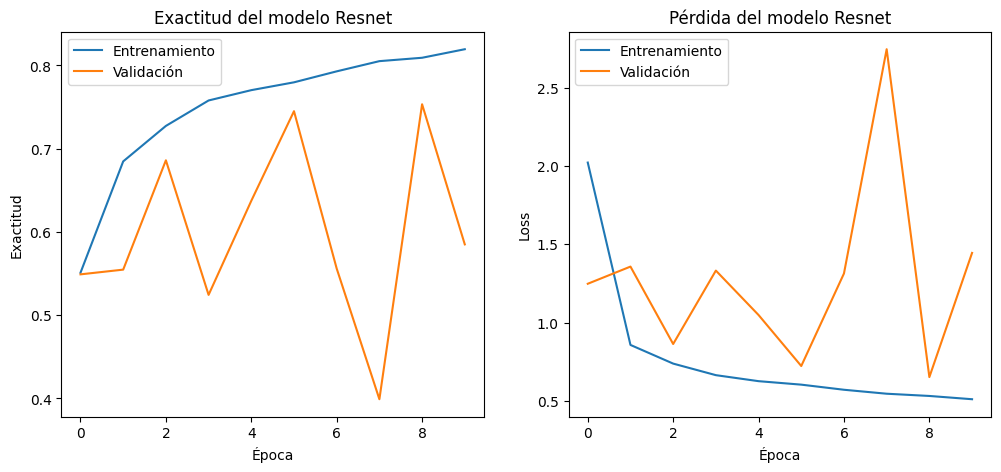

In [ ]:
plt.figure(figsize=(12,5))

# Exactitud
plt.subplot(1,2,1)
plt.plot(history_resnet.history['accuracy'], label='Entrenamiento')
plt.plot(history_resnet.history['val_accuracy'], label='Validación')
plt.title('Exactitud del modelo Resnet')
plt.xlabel('Época')
plt.ylabel('Exactitud')
plt.legend()

# Pérdida
plt.subplot(1,2,2)
plt.plot(history_resnet.history['loss'], label='Entrenamiento')
plt.plot(history_resnet.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo Resnet')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.show()


El modelo logra una exactitud (accuracy) de 0.7824 en los datos de test.
Se observa un comportamiento muy caótico en la curva de validación lo que podría significar que el modelo se ajusta mucho a los datos de entrenamiento.

## Prediccion con Resnet

188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step


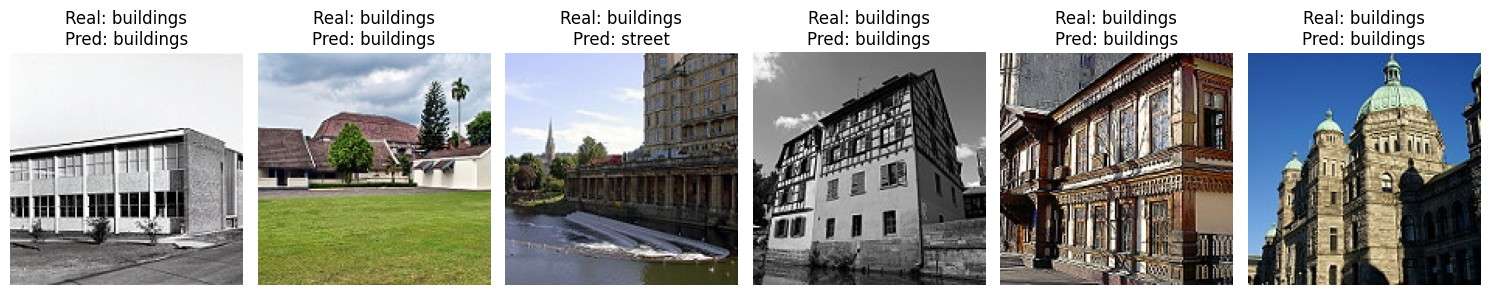

In [ ]:
# Predicciones sobre el conjunto de test
predictions_res = model_resnet.predict(test_generator, verbose=1)

# Convertir de probabilidades a clases
y_pred_res = np.argmax(predictions_res, axis=1)

# Obtener un batch del conjunto de test
x_batch, y_batch = next(test_generator)

# Asegurarnos de que el batch tenga al menos 6 imágenes
num_images = min(6, len(x_batch))

# Obtener nombres de clases
class_names = list(test_generator.class_indices.keys())

# Crear una figura para mostrar 6 imágenes
plt.figure(figsize=(15, 5))

for i in range(num_images):
    img = x_batch[i]
    true_label = np.argmax(y_batch[i])

    # Hacer la predicción
    pred_res = model_resnet.predict(np.expand_dims(img, axis=0), verbose=0)
    pred_label_res = np.argmax(pred_res)

    # Subplot para cada imagen
    plt.subplot(1, num_images, i+1)
    plt.imshow((img * 255).astype("uint8"))
    plt.axis('off')
    plt.title(f"Real: {class_names[true_label]}\nPred: {class_names[pred_label_res]}")

plt.tight_layout()
plt.show()


# Modelo Transfer Learning


Data Augmentation para TransferLearning.

In [ ]:
train_datagen_tl = ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=20,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode='nearest'
)
test_datagen_tl = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator_tl = train_datagen_tl.flow_from_directory(
  train_dir, target_size=(224,224), batch_size=32, class_mode='categorical'
)
test_generator_tl = test_datagen_tl.flow_from_directory(
  test_dir, target_size=(224,224), batch_size=16, class_mode='categorical', shuffle=False

)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


Definimos la arquitectura de la red.

In [ ]:
def build_model(input_shape, num_classes):
  base_model = tf.keras.applications.EfficientNetB0(input_shape=input_shape,
                                              include_top=False,
                                              weights='imagenet')
  base_model.trainable = False

  i = Input(shape=input_shape)
  x = base_model(i, training=False)
  x = GlobalAveragePooling2D()(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(num_classes, activation='softmax')(x)

  return tf.keras.Model(i, x)

Construimos y visualizamos el resumen del modelo.

In [ ]:
print("Building model")
num_classes = 6
input_shape = (224,224,3)

model_tl = build_model(input_shape, num_classes=num_classes)

model_tl.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=['accuracy'])

model_tl.summary()

Building model
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,379,049 (16.70 MB)

 Trainable params: 329,478 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Entrenamos el modelo.

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=0, mode="min")
checkpoint_acc = ModelCheckpoint(
    '/content/drive/MyDrive/TP3_Modelos/best_model_tl.keras',
    save_best_only=True,
    monitor="val_accuracy",
    initial_value_threshold=0.7,
    mode="max",
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, verbose=1, min_delta=1e-4, mode="min"
)

In [ ]:
print("Entrenando EfficientNetB0 (fase 1: capas congeladas)")
history_tl = model_tl.fit(train_generator_tl, validation_data=test_generator_tl, epochs=5, callbacks=[checkpoint_acc, reduce_lr, early_stopping])

# Fine-tuning
base_model = model_tl.layers[1]
base_model.trainable = True
for layer in base_model.layers[:-20]:
  layer.trainable = False

model_tl.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy']) #Disminuyo el learning rate del optimizador
print("Entrenando EfficientNetB0 (fase 2: fine-tuning)")
history_tl_fine = model_tl.fit(train_generator_tl, validation_data=test_generator_tl, epochs=10, callbacks=[checkpoint_acc, reduce_lr, early_stopping])

Entrenando EfficientNetB0 (fase 1: capas congeladas)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 233s 462ms/step - accuracy: 0.8394 - loss: 0.4439 - val_accuracy: 0.9233 - val_loss: 0.2157 - learning_rate: 0.0010
Epoch 2/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 163s 372ms/step - accuracy: 0.9075 - loss: 0.2494 - val_accuracy: 0.9200 - val_loss: 0.2125 - learning_rate: 0.0010
Epoch 3/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 164s 372ms/step - accuracy: 0.9117 - loss: 0.2272 - val_accuracy: 0.9300 - val_loss: 0.2082 - learning_rate: 0.0010
Epoch 4/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 163s 372ms/step - accuracy: 0.9239 - loss: 0.2155 - val_accuracy: 0.9233 - val_loss: 0.2204 - learning_rate: 0.0010
Epoch 5/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 173s 394ms/step - accuracy: 0.9217 - loss: 0.2178 - val_accuracy: 0.9267 - val_loss: 0.2023 - learning_rate: 0.0010
Entrenando EfficientNetB0 (fase 2: fine-tuning)
Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 214s 431ms/step - accuracy: 0.8348 - loss: 0.4548 - val_accuracy: 0.9027 - val_loss: 0.2938 - learning_rate: 1.0000e-05
Epoch 2/10
439/43

Visualizamos la exactitud (accuracy) y función de pérdida para los datos de entrenamiento y validación.

In [ ]:
# Obtener las métricas del entrenamiento
val_acc = history_tl_fine.history['val_accuracy']
val_loss = history_tl_fine.history['val_loss']

# Calcular los mejores valores
best_val_acc = max(val_acc)
best_val_loss = min(val_loss)
best_epoch = np.argmax(val_acc) + 1  # +1 porque los índices empiezan en 0

print(f"✅ Mejor Epoch: {best_epoch}")
print(f"📈 Mejor Valid Accuracy: {best_val_acc:.4f}")
print(f"📉 Mejor Valid Loss: {best_val_loss:.4f}")

✅ Mejor Epoch: 10
📈 Mejor Valid Accuracy: 0.9287
📉 Mejor Valid Loss: 0.2107


Evaluamos el modelo para el conjunto de test.

In [ ]:
# Evaluación en el conjunto de test
test_loss_tl, test_acc_tl = model_tl.evaluate(test_generator_tl, verbose=1)
print(f"Test Accuracy TL: {test_acc_tl:.4f}")
print(f"Test Loss TL: {test_loss_tl:.4f}")


188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9317 - loss: 0.2080
Test Accuracy TL: 0.9287
Test Loss TL: 0.2112


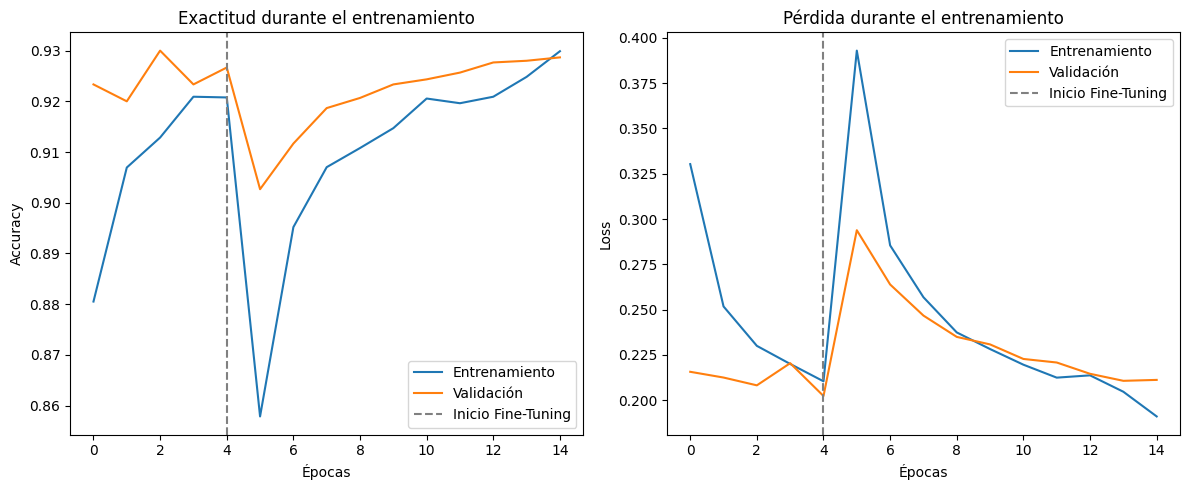

In [ ]:
# Unir los historiales de ambas fases
acc = history_tl.history['accuracy'] + history_tl_fine.history['accuracy']
val_acc = history_tl.history['val_accuracy'] + history_tl_fine.history['val_accuracy']
loss = history_tl.history['loss'] + history_tl_fine.history['loss']
val_loss = history_tl.history['val_loss'] + history_tl_fine.history['val_loss']

# Curvas de exactitud y pérdida
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(acc, label='Entrenamiento')
plt.plot(val_acc, label='Validación')
plt.axvline(x=len(history_tl.history['accuracy'])-1, color='gray', linestyle='--', label='Inicio Fine-Tuning')
plt.title('Exactitud durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.axvline(x=len(history_tl.history['loss'])-1, color='gray', linestyle='--', label='Inicio Fine-Tuning')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


El modelo logra una alta exactitud en el conjunto de test con un accuracy de 0.9287. El fine-tuning no mejoró el rendimiento del modelo, puede necesitar más épocas para hacerlo o que el rendimiento del modelo no pueda ser mejorado con el dataset dado.

# Comparacion de modelos

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step


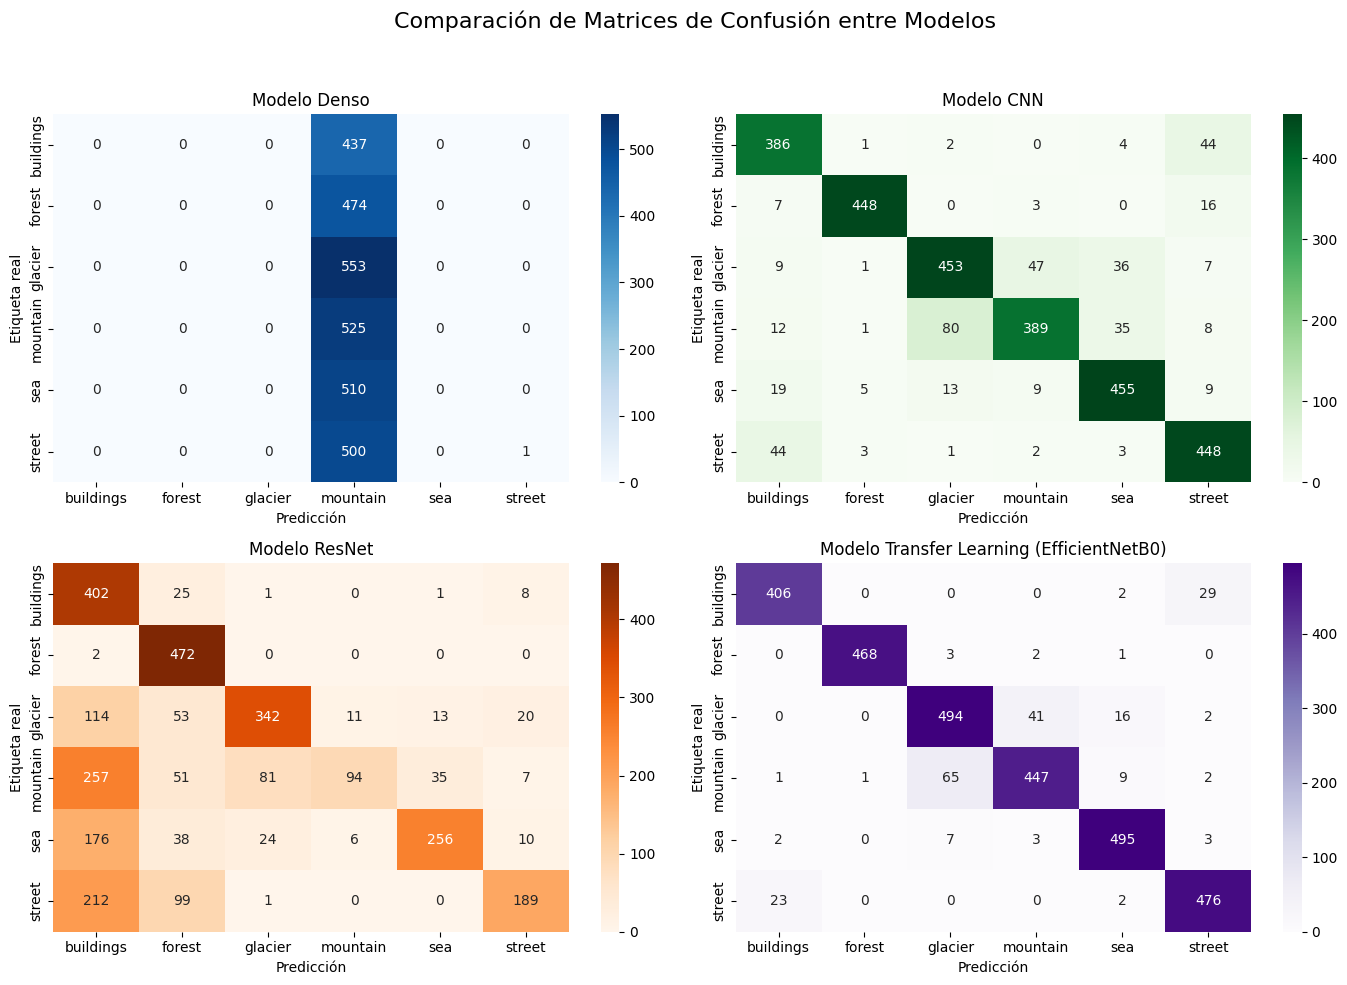

In [ ]:
# Función para obtener predicciones y matriz de confusión
def get_confusion_matrix_and_report(model, generator, model_name):
    # Predicciones del modelo
    Y_pred = model.predict(generator)
    y_pred = np.argmax(Y_pred, axis=1)

    # Matriz de confusión
    cm = confusion_matrix(generator.classes, y_pred)
    labels = list(generator.class_indices.keys())

    # Reporte de clasificación
    #print(f"\nReporte de clasificación para {model_name}")
    #print(classification_report(generator.classes, y_pred, target_names=labels))

    return cm, labels

# Obtener matrices de confusión
cm_dense, labels = get_confusion_matrix_and_report(model_dense, test_generator, "Modelo Denso")
cm_cnn, _ = get_confusion_matrix_and_report(model_cnn, test_generator, "Modelo CNN")
cm_resnet, _ = get_confusion_matrix_and_report(model_resnet, test_generator, "Modelo ResNet")
cm_tl, labels_tl = get_confusion_matrix_and_report(model_tl, test_generator_tl, "Modelo Transfer Learning (EfficientNetB0)")

# Gráfico comparativo
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Comparación de Matrices de Confusión entre Modelos', fontsize=16)

sns.heatmap(cm_dense, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
            xticklabels=labels, yticklabels=labels)
axes[0,0].set_title('Modelo Denso')

sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Greens', ax=axes[0,1],
            xticklabels=labels, yticklabels=labels)
axes[0,1].set_title('Modelo CNN')

sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Oranges', ax=axes[1,0],
            xticklabels=labels, yticklabels=labels)
axes[1,0].set_title('Modelo ResNet')

sns.heatmap(cm_tl, annot=True, fmt='d', cmap='Purples', ax=axes[1,1],
            xticklabels=labels_tl, yticklabels=labels_tl)
axes[1,1].set_title('Modelo Transfer Learning (EfficientNetB0)')

for ax in axes.flat:
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Etiqueta real')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
# Resultados
results = {
    "Modelo": ["Dense", "CNN", "ResNet", "Transfer Learning"],
    "Accuracy": [test_acc_dense, test_acc_cnn, test_acc_res, test_acc_tl]}
# Convertir en DataFrame
df_results = pd.DataFrame(results)
print(df_results)


              Modelo  Accuracy
0              Dense  0.175333
1                CNN  0.859667
2             ResNet  0.585000
3  Transfer Learning  0.928667


## Elección de modelo final

* **Modelo Denso:** El accuracy bajo del modelo se debe a que predice una única clase (mountain) en todos los casos.

* **Modelo CNN:** Tiene un buen equilibrio entre clases con algunos errores en clases similares. El modelo aprendió patrones útiles y logra un buen desempeño general.

* **Modelo ResNet:** El modelo si bien tiene un accuracy relativamente bueno, confunde algunas clases y comete bastantes errores cuando predice buildings.

* **Modelo Transfer Learning:** Muy buena clasificación en todas las clases con pocas confusiones. Es el modelo que logra mejores resultados en todos los aspectos.

Dada la comparación y análisis de las matrices de confunsión, el modelo seleccionado para realizar las predicciones es el de Transfer Learning.


#Predicciones con modelo de Transfer Learning

Procedemos a realizar las predicciones del modelo de transfer learning sobre el conjunto de test. A continuación, visualizamos tres imágenes mal clasificadas por cada clase, con el objetivo de analizar y comprender las posibles razones por las cuales el modelo comete estos errores de clasificación.

188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
Total de errores: 214


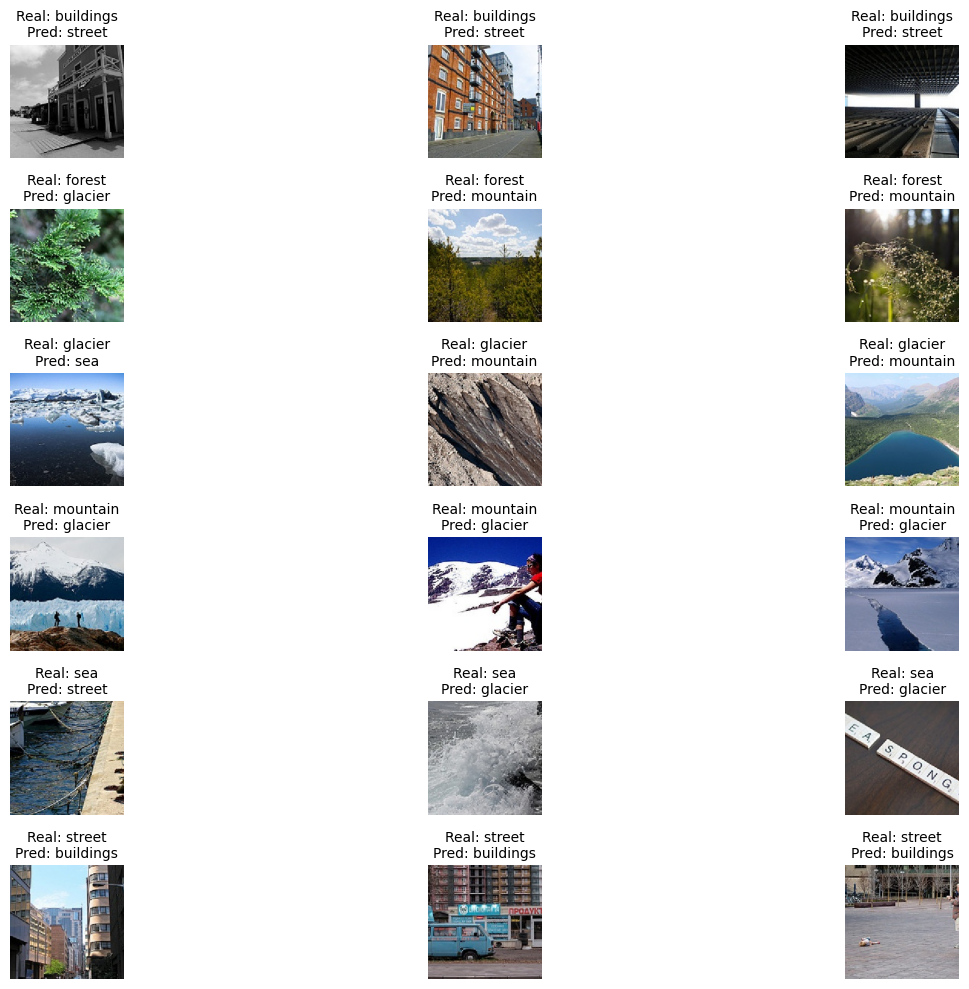

In [ ]:
#  Obtener predicciones sobre todo el conjunto de test
predictions = model_tl.predict(test_generator_tl, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator_tl.classes

#  Obtener rutas de las imágenes
filenames = test_generator_tl.filenames
class_names = list(test_generator_tl.class_indices.keys())

#  Encontrar los índices donde el modelo falla
misclassified_idx = np.where(y_pred != y_true)[0]
print(f"Total de errores: {len(misclassified_idx)}")

#  Agrupar los errores por clase real
errors_by_class = {cls: [] for cls in range(len(class_names))}
for idx in misclassified_idx:
    true_class = y_true[idx]
    errors_by_class[true_class].append(idx)

#  Mostrar hasta 3 imágenes mal clasificadas por clase
plt.figure(figsize=(15, 10))
plot_index = 1

for cls_idx, indices in errors_by_class.items():
    if len(indices) == 0:
        continue  # si no hay errores en esa clase, la salteamos

    for i in indices[:3]:  # tomar hasta 3 errores
        img_path = os.path.join(test_dir, filenames[i])
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img).astype("uint8")

        plt.subplot(len(class_names), 3, plot_index)
        plt.imshow(img_array.astype("uint8"))
        plt.axis('off')

        plt.title(
            f"Real: {class_names[y_true[i]]}\nPred: {class_names[y_pred[i]]}",
            fontsize=10
        )

        plot_index += 1

plt.tight_layout()
plt.show()


# Conclusiones

Observamos que el modelo comete errores lógicos al confundir algunas clases, por ejemplo, entre buildings y street, ya que ciertas imágenes podrían pertenecer a ambas categorías. Situaciones similares ocurren entre glacier y mountain, o entre glacier y sea. Además, se detectaron algunas imágenes mal etiquetadas en la clase glacier y una imagen que no corresponde a ninguna categoría, en el caso de sea.

En conclusión, no se puede mejorar las métricas del modelo, y sería recomendable reconsiderar la exclusividad de las categorías, permitiendo que una imagen pueda pertenecer a más de una clase para obtener predicciones más coherentes y precisas.

